## Sentiment Analysis
### Using Sentiment140 Tweet Corpus & SemEval Corpus Combined



In [1]:
# Load Packages

# Standard python helper libraries.
import collections
import itertools
import json
import os
import re
import sys
import time

# Numerical manipulation libraries.
import numpy as np
import pandas as pd
# from scipy import stats
# import scipy.optimize

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.

# Helper libraries (from w266 Materials).
# import segment
#from shared_lib import utils
# from shared_lib import vocabulary

# Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Word2Vec Model
import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.models import load_model

# Data Viz
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Python Reddit API Wrapper
import praw

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


### Load in Corpora & Clean

#### SemEval Corpus
Explanation of corpus.

Must download Tweet Data on your own, using the tutorial and code found here https://github.com/seirasto/twitter_download

In [2]:
# Load data as a pandas dataframe
cols = ['TweetID', 'Sentiment', 'SentimentText']
tweets = pd.read_table("Data/twitter_download-master/ALL_SEMEVAL_TRAIN_DATA.txt", header=None,
                       names=cols, encoding='ISO-8859-1', error_bad_lines=False)

# Drop extra columns
tweets.drop(['TweetID'], axis=1, inplace=True)

# # Remove Null Tweets
# tweets = tweets[tweets.Sentiment.isnull() == False]

# Map Integers to each of the categorical data (match with Sentiment 140 encoding)
tweets['Sentiment'] = tweets['Sentiment'].map({'negative':0, 'neutral':2, 'positive':4})

#### Sentiment 140 Corpus
Explanation of corpus.

In [3]:
# Load data as a pandas dataframe
cols2 = ['Sentiment', 'ItemID', 'DateTime', 'Query', 'SentimentSource', 'SentimentText']
tweets2 = pd.read_csv('Data/milliontweetCorpus/training.1600000.processed.noemoticon.csv', 
                     header=None, names=cols2, encoding='ISO-8859-1', error_bad_lines=False) #, nrows=num_tweets)

# Drop extra columns
tweets2.drop(['ItemID', 'DateTime', 'Query', 'SentimentSource'], axis=1, inplace=True)

# # Remove Null Tweets
# tweets2 = tweets2[tweets2.Sentiment.isnull() == False]

# Map Integers to each of the categorical data (0: Negative, 4: Positive)
tweets2['Sentiment'] = tweets2['Sentiment'].map(int)


Combine corpora

In [4]:
# Combine Dataframes
tweets = pd.concat([tweets,tweets2], axis=0)

# Remove Null Tweets, show shape, and print first 5 tweets
tweets = tweets[tweets['SentimentText'].isnull() == False]
tweets = tweets[tweets['SentimentText'] != 'Not Available']
tweets.reset_index(inplace=True)
tweets.drop('index', axis=1, inplace=True)
print('Concatenated DataFrame Shape:', tweets.shape)


Concatenated DataFrame Shape: (1616667, 2)


#### Explore a few of the Tweets

In [5]:
# Print a bunch of Random Tweets
i = 0
while i < 20:
    current = np.random.randint(0,tweets.shape[0]-1)
    sent = tweets.Sentiment[current]
    text = tweets.SentimentText[current]
    if sent == 0:
        i += 1
        print('Negative Tweet:', text)
    if sent == 4:
        i += 1
        print('Positive Tweet:', text)
    else:
        continue

Positive Tweet: the rain is coming . . . and i got my new Gap umbrella. 
Negative Tweet: @DJSTUPAC  dont look like imma be able to make it. im moving this week so funds are super tight. very sad behind that too 
Positive Tweet: June 16th is going to be a great day 
Negative Tweet: @the_crooked_toe yep hard fight  lots of business contacts replied wnt use their work email b/c they expect veeam spam. Lost 23 votes 
Positive Tweet: Going to eat icecream and watch Godhand Teru. 
Negative Tweet: @Maggiemelba ouch  all better now? Coming to work today?
Negative Tweet: Going to go work out. Then meetings all day 
Positive Tweet: @randomdrunk Wonder what a coco-pops pizza would be like? Not too sure, but still tempted to try a baked-bean one! Sad eh? 
Negative Tweet: im really really ill 
Positive Tweet: @masterlesamurai haha yeah gradma's boy is total b comedy.i enjoyed it still.Its always sunny in philadelphia, ul thank me  BEST THING EVA
Negative Tweet: wishing you were somehow here again..

General thoughts of the corpora above:
1. Emoticons were removed from the Sentiment140 database but were NOT removed from the SemEval database. This could cause the model to pick up on that sequence of characters (ie. :(, =)) as defining features. Should remove.
2. Definitely some tweets I would say are miscategorized. For example: 'I love my sister a.k.a brianna!!! Missing her..we might be away by distance,never in heart..' is labeled Negative due to the presence of a :( in the original tweet. The accuracy of any model trying to predict Positive/Negative Sentiment on this corpus will consistently struggle to approach perfection due to these types of labels.
3. The general sentence structure here is grammatically awful and may not translate well to Reddit where individuals tend to hold more of a long-form conversation. 

### Cleaning

#### Tokenizing each Tweet

In [6]:
# Use NLTK's Tweet Tokenizer
t = TweetTokenizer()

def create_tokens(tweet):
    
    # Adjust all words in sentence to Lowercase
    tweet = str(tweet.lower())
    
    #Tokenize the sentence
    tokens = t.tokenize(tweet)
    
    # Filter out some unnecessary links, mentions, retweets, handles, and emoticons
    tokens = list(filter(lambda x: not x.startswith('@'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('#'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('RT'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('http'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':)'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':-)'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(': )'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':D'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('=)'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':('), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':-('), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(': ('), tokens)) ##
    return tokens

tweets['SentimentTextTokenized'] = tweets['SentimentText'].apply(create_tokens)
tweets.head()


X = tweets.SentimentTextTokenized
Y = tweets.Sentiment

#### Visual Exploration (we can do better, if time)

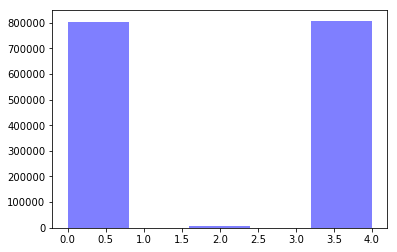

In [7]:
num_bins = 5
n, bins, patches = plt.hist(tweets.Sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Because the two corpora are combined, we see 3 categories in this Training Dataset. Negative = 0, Neutral = 2, Positive = 4

### Preprocessing & Feature Engineering

In [8]:
# Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=100)

print(X_train[:5])
print(y_train[:5])

1418399    [just, did, a, test, drive, with, the, bmw, 11...
1590568    [good, luck, lauren, ., i, know, you, are, goi...
1426864    [shipley's, donuts, sounds, amazing, right, no...
711160     [i, dont, like, it, at, all, ., its, confusing...
1576708                          [i, got, it, ..., hehehehe]
Name: SentimentTextTokenized, dtype: object
1418399    4
1590568    4
1426864    4
711160     0
1576708    4
Name: Sentiment, dtype: int64


### Convert Words into Vector Representation

Leveraging GenSim's Word2Vec model to convert our vocabulary into a vocabulary of word vectors.

In [9]:
# Specify the Word Vector Dimensionality
vector_dim = 100

# Threshold for words to be included (helps remove rare words)
thresh = 5

W2Vmodel = Word2Vec(size=vector_dim, min_count=thresh)
W2Vmodel.build_vocab(x for x in X_train)
W2Vmodel.train((x for x in X_train), total_examples=W2Vmodel.corpus_count, epochs=2)

14001331

Explore a few similar words using Word2Vec's most_similar function

In [10]:
def print_similar(word):
    print('##### %s #####' %word)
    for each in W2Vmodel.most_similar(str(word)):
        print('%i%% %s' %(each[1]*100, each[0]))
    print('')

print_similar('potato')
print_similar('hilarious')
print_similar('tuesday')
print_similar('trump')    

##### potato #####
93% grilled
91% fried
91% sausage
91% garlic
90% homemade
90% choc
90% cinnamon
90% blueberry
90% pasta
90% banana

##### hilarious #####
82% funny
79% dope
77% brilliant
75% scary
75% awesome
74% amazing
74% awsome
74% adorable
71% incredible
68% ace

##### tuesday #####
95% wednesday
90% thursday
87% monday
85% friday
83% wed
81% tues
79% thurs
79% saturday
77% fri
76% sunday

##### trump #####
86% donald
82% obama
81% jeb
79% merkel
79% sanders
79% bush
79% harper
77% jindal
77% pope
76% president



### Convert Tweets into Vector Representation

First attempt was to simply average all of the word vectors present in a single tweet.

Second attempt utilized TFIDF rankings for each word to take into account the rarity/importance of that word within the overall corpus. 



In [11]:
def buildTweetVector(tokens, vector_dim):
    
    # Initialize a blank vector of shape (1,vector_dim)
    tweet_vec = np.zeros(vector_dim).reshape((1, vector_dim))
    
    # Initialize # of words in tweet count
    count = 0.
    
    for word in tokens:
        try:
            # Take each word vector in the tweet and add each dimension to the overall tweet vector
            tweet_vec += W2Vmodel[word].reshape((1, vector_dim))
            
            # Increment Count
            count += 1.
            
        except:
            continue
    
    # Average each vector parameter by the # of words in the tweet (pass if no words exist in tweet)
    if count != 0:
        tweet_vec /= count
    
    # Return Tweet Vector
    return tweet_vec

#### Build TFIDF Dictionary

In [12]:
# Fit a TFIDF vectorizer model to the training set
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
vectorizer.fit_transform([x for x in X_train])

# Extract IDF values from model and place into a dictionary
tfidf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [13]:
def buildTweetVectorTFIDF(tokens, vector_dim):
    
    # Initialize a blank vector of shape (1,vector_dim)
    tweet_vec = np.zeros(vector_dim).reshape((1, vector_dim))
    
    # Initialize # of words in tweet count
    count = 0.
    
    for word in tokens:
        try:
            # Same as above, only now multiply the tfidf score for the current word by its vector 
            # (to add additional weight to more important words with respect to the corpus)
            tweet_vec += W2Vmodel[word].reshape((1, vector_dim)) * tfidf_dict[word]
            
            # Increment Count
            count += 1.
            
        except:
            continue
    
    # Average each vector parameter by the # of words in the tweet (pass if no words exist in tweet)
    if count != 0:
        tweet_vec /= count
    
    # Return Tweet Vector
    return tweet_vec

#### Turn Training and Test Sets into Tweet Vectors
Pass each tweet in the Training/Test Sets into the buildTweetVector function and reassemble training/test set structure

In [14]:
X_train_tweet_vecs = np.concatenate([buildTweetVectorTFIDF(vec, vector_dim) for vec in map(lambda x: x, X_train)])
X_test_tweet_vecs = np.concatenate([buildTweetVectorTFIDF(vec, vector_dim) for vec in map(lambda x: x, X_test)])

#### Scale each Vector

In [15]:
scaler = StandardScaler()
scaler.fit(X_train_tweet_vecs)
X_train_tweet_vecs = scaler.transform(X_train_tweet_vecs)
X_test_tweet_vecs = scaler.transform(X_test_tweet_vecs)

#### Encode the Y Labels as Categorical Variable and then One-hot Encode (for multi-class classification)

In [16]:
print("Original Y:", y_train[:10])
encoder = LabelEncoder()
encoder.fit(Y)
y_train = encoder.transform(y_train)
y_test= encoder.transform(y_test)
print("Encoded Y:", y_train[:10])

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print("One Hot Y:", y_train[:10])

Original Y: 1418399    4
1590568    4
1426864    4
711160     0
1576708    4
54615      0
6138       2
974273     4
84989      0
1397183    4
Name: Sentiment, dtype: int64
Encoded Y: [2 2 2 0 2 0 1 2 0 2]
One Hot Y: [[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]


## Fit a 'Simple' Neural Network Model using the Tweet Vectors as Features

Using Keras & Tensorflow backend.

In [17]:
# Keras Model w/ Two Affine Layers
model = Sequential()
model.add(Dense(32, activation='softmax', input_dim=vector_dim))
model.add(Dense(3, activation='softmax')) # softmax for multi-class
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', # categorical_crossentropy if multi-class
              metrics=['accuracy'])

model.fit(X_train_tweet_vecs, y_train, epochs=1, batch_size=32, verbose=2)

Epoch 1/1
 - 30s - loss: 0.5042 - acc: 0.7648


#### Evaluate Model on Test Set

In [18]:
accuracy = model.evaluate(X_test_tweet_vecs, y_test, batch_size=32, verbose=2)
print("Accuracy: %.2f%%" % (accuracy[1]*100))

Accuracy: 77.14%


#### Save Keras Model

In [19]:
# Save Keras Model to File (not working on Matt's computer)
# model.save('sentiment_model.h5')

### Apply Fitted Model to Reddit

In [20]:
# Function to Predict Positive/Neutral/Negative
# def prediction(text):
#     sentiment = ["Negative",'Neutral', "Positive"]
#     text = text.split() # Tokenize
#     text = buildTweetVectorTFIDF(text, vector_dim)
#     text = scaler.transform(text)
#     prediction = model.predict(text, batch_size=32)
#     result = sentiment[prediction.argmax(axis=1)[0]]
#     return result

def prediction(text):
    sentiment = ["Negative",'Neutral', "Positive"]
    tokens = create_tokens(text)
    vectors = buildTweetVectorTFIDF(tokens, vector_dim)
    vectors = scaler.transform(vectors)
    predic = model.predict(vectors)
    result = sentiment[predic.argmax(axis=1)[0]]
    return result

# Load saved Keras Model from File (not working on Matt's computer)
# my_model = load_model('sentiment_model.h5')

#### Using the praw package to interact with Reddit's API and pull all comments from a single page

In [21]:
# Initialize a read-only instance
reddit = praw.Reddit(user_agent='first_scrape (by /u/dswald)',
                     client_id='TyAK1zSuAvQjmA', 
                     client_secret="uxHGsL0zNODbowN6umVnBWpqLAQ")

# Select Url / Subreddit page to view
page = 'portland'

subreddit = reddit.subreddit(page)
hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts

for submission in hot_python:
    if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'
        print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(submission.title,
                                                                          submission.ups,
                                                                          submission.downs,
                                                                          submission.visited))
        comments = submission.comments.list() #unstructured
        for comment in comments:
            print (20*'-')
            print ('Parent ID:', comment.parent())
            print ('Comment ID:', comment.id)
            print (comment.body)
            print("#"*10,'PREDICTED SENTIMENT:', prediction(comment.body),"#"*10)

Title: As many of the bridges as I can get in one panorama!, ups: 585, downs: 0, Have we visited: False
--------------------
Parent ID: 7iko02
Comment ID: dqzjf48
Now that is something different.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7iko02
Comment ID: dqzlrk2
Seriously stunning shot.  The next couple of days are offering such a fantastic opportunity for great light, visibility and Alpenglow for photography.  If I had the talent I'd be all over it, but since I don't I'm genuinely appreciating your contribution. I work in Big Pink so I particularly like the shot. 
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7iko02
Comment ID: dqzm3le
Holy butts. This photo makes me realize how many shipping containers a major city needs. 13/10 more plz
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: 7iko02
Comment ID: dqznesx
That's beautiful! I love the Christmas-themed freights lea

### Limitations of this corpora on the Reddit Feeds

Unfortunately, sentence structure on Reddit appears to be substantially different compared to tweet structure on Twitter both in grammar use and in length of post. Because the model was built using a corpus that is only 140 characters long (maximum). Considering the creation of a Tweet vector is just an averaging across all of the individual word vectors, theoretically this process should translate to a full Reddit sentence though due to the increased length of a Reddit sentence any 'rare' or 'important words' seen will be more likely to be averaged out in a longer post.

# -----DEVELOPMENT AREA-------

# Trying to Visualize a Network with Positive Nodes = Green, Neg=Red

Title: Jozy Atlidore goal vs. Seattle [MLS CUP], ups: 79, downs: 0, Have we visited: False


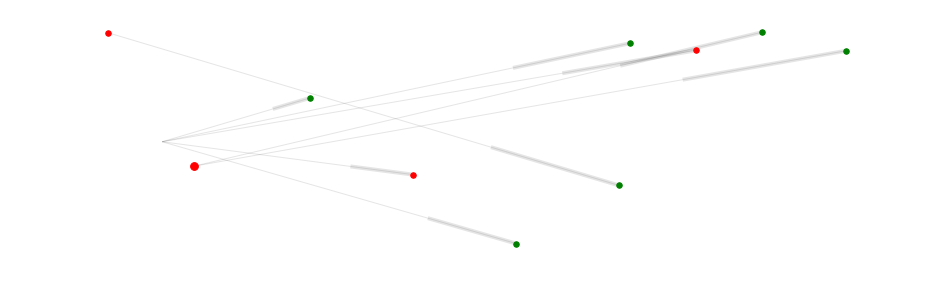

Overall Page Positivity Score: 60.00%
Overall Weighted Page Positivity Score: 54.55%

Title: MLS CUP CHAMPS!!!, ups: 384, downs: 0, Have we visited: False


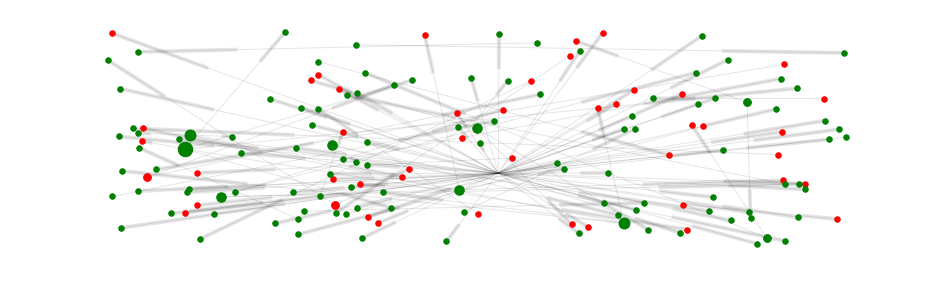

Overall Page Positivity Score: 70.89%
Overall Weighted Page Positivity Score: 73.63%

Title: <-----NUMBER OF SALTY SEATTLE SOUNDER TEARS!!!!! TORONTO FC ARE YOUR 2017 MLS CUP CHAMPIONS!!!!!, ups: 196, downs: 0, Have we visited: False


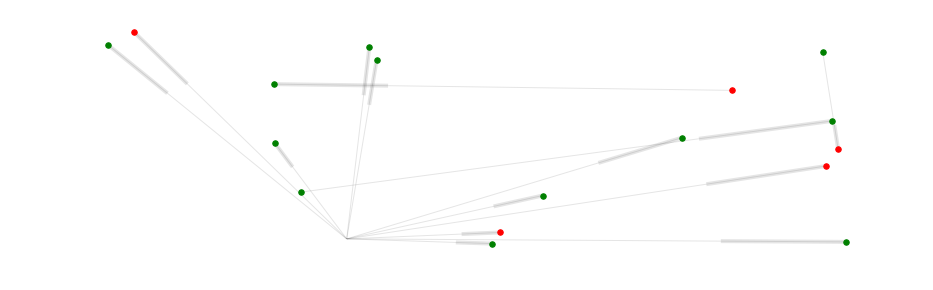

Overall Page Positivity Score: 70.59%
Overall Weighted Page Positivity Score: 70.59%



In [162]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter, defaultdict

# Initialize a read-only instance
reddit = praw.Reddit(user_agent='first_scrape (by /u/dswald)',
                     client_id='TyAK1zSuAvQjmA', 
                     client_secret="uxHGsL0zNODbowN6umVnBWpqLAQ")

# Select Url / Subreddit page to view
page = 'tfc'

subreddit = reddit.subreddit(page)
hot_python = subreddit.hot(limit = 5) #need to view >2 to get past promoted posts

G_dict = {}

for submission in hot_python:
    if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'

        comments = submission.comments.list() #unstructured
        G = nx.DiGraph()
        positive_nodes = []
        negative_nodes = []
        # Build empty dict
        degrees = {}
        for i in range(1,30):
            degrees[i] = []
            
        for comment in comments:
            try:
                sentiment = str(prediction(comment.body))
                if sentiment == "Negative":
                    negative_nodes.append(comment.id)
#                     degree.append(nx.degree(G))
                if sentiment == "Positive":
                    positive_nodes.append(comment.id)
                G.add_node(comment.id)
                G.add_edge(comment.parent(), comment.id)
            except:
                continue
            
        degree = nx.degree(G)
        for id,count in degree.items():
            for i in range(1,30):
                if count == i:
                    degrees[i].append(id)
        G_dict[submission] = (G, positive_nodes, negative_nodes, degrees)
        


i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.random_layout(G[0])
    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)
    total_pos_score = 0
    total_neg_score = 0
    total_weighted_pos_score = 0
    total_weighted_neg_score = 0
    
    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
                total_weighted_pos_score += j*1
                total_pos_score += 1
            if k in G[2]:
                neg_j.append(k)
                total_weighted_neg_score += j*1
                total_neg_score += 1
                
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
        
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()
    
    overall_page_score = total_pos_score / (total_pos_score + total_neg_score)
    overall_weighted_page_score = total_weighted_pos_score / (total_weighted_pos_score + total_weighted_neg_score)
    print("Overall Page Positivity Score: %0.2f%%" %(overall_page_score*100))
    print("Overall Weighted Page Positivity Score: %0.2f%%" %(overall_weighted_page_score*100))
    print("")



### Generating an overall score for each Post on a Subreddit

In [ ]:
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))